In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsFinalDataset
from pathlib import Path

import matplotlib.pyplot as plt

from dtw import dtw

In [2]:
noise_type='gaussian'

In [3]:
# Dataset loader
datapath = Path('data')
dataset = TsFinalDataset(datapath/'CaseI-Attacks without any change.csv', noise_type=noise_type)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        shuffle=True, num_workers=4)
print("The size of the dataset is: ", dataset.data_normal.size(), dataset.data_attacked.size())

The size of the dataset is:  torch.Size([1, 2045, 33]) torch.Size([1, 2045, 33])


In [4]:
normal_seq_len = dataset.data_normal.size(1)
normal_feature_len = dataset.data_normal.size(2)
abnormal_seq_len = dataset.data_attacked.size(1)
abnormal_feature_len = dataset.data_attacked.size(2)

In [5]:
G_AB = LSTMFullGenerator(normal_seq_len, normal_feature_len)
G_BA = LSTMFullGenerator(abnormal_seq_len, abnormal_feature_len)
D_A = LSTMFullDiscriminator(normal_feature_len)
D_B = LSTMFullDiscriminator(normal_feature_len)

In [6]:
G_AB.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_AB_190.pth"))
G_BA.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_BA_190.pth"))
D_A.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_A_190.pth"))
D_B.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_B_190.pth"))

<All keys matched successfully>

In [7]:
G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMFullDiscriminator(
  (lstm): LSTM(33, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=33, bias=True)
    (1): Sigmoid()
  )
)

In [8]:
threshold = 1.007

In [9]:
dataset_test = TsFinalDataset(datapath/'CaseII.csv', noise_type='none')
# dataset_test = TsFullDataset(datapath/'CaseI-Attacks without any change.csv')
dataset_test.data_normal.size()

torch.Size([15, 1973, 33])

In [10]:
with torch.no_grad():
    output = G_AB(dataset_test.data_normal)
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([15, 1973, 33]) 	 Output Back size: torch.Size([15, 1973, 33])


In [11]:
os.makedirs(f'cyber_result/true/{noise_type}/forward', exist_ok=True)
forward_res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, :, 0].numpy())
    plt.plot(output_back[i, :, 0].numpy())
    plt.plot(dataset_test.data_normal[i, :, 0].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/true/{noise_type}/forward/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,:,0].reshape(-1, 1), dataset_test.data_normal[i,:,0].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,:,0].reshape(-1, 1), output[i,:,0].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,:,0].reshape(-1, 1), dataset_test.data_normal[i,:,0].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    res = (dist2+dist3)/dist1
    print("+" if res < threshold else "-", res)
    forward_res_list.append(res)

+ 1.000450552578472
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505524961187
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525314251
+ 1.0004505525196634


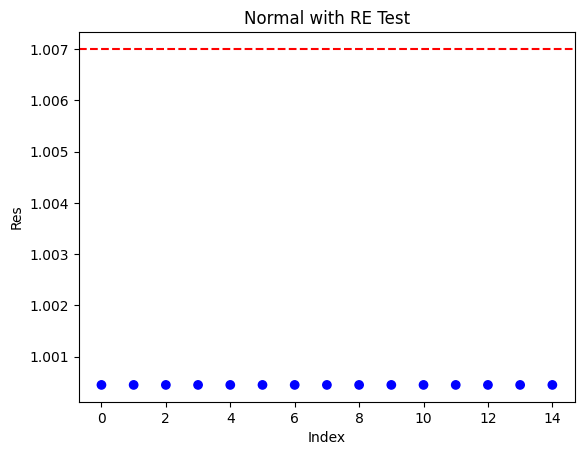

In [12]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in forward_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(forward_res_list)), forward_res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Normal with RE Test')
plt.show()

---

In [13]:
dataset_test.data_attacked.size()

torch.Size([15, 1973, 33])

In [14]:
data_noisy_test = dataset.data_attacked
data_noisy_test.size()

torch.Size([1, 2045, 33])

In [15]:
with torch.no_grad():
    output = G_AB(data_noisy_test)
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([1, 2045, 33]) 	 Output Back size: torch.Size([1, 2045, 33])


In [16]:
os.makedirs(f'cyber_result/true/{noise_type}/detection', exist_ok=True)
detection_res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, :, 0].numpy())
    plt.plot(output_back[i, :, 0].numpy())
    plt.plot(data_noisy_test[i, :, 0].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/true/{noise_type}/detection/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), data_noisy_test[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), data_noisy_test[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1)) 
    res = (dist2+dist3)/dist1   
    print("+" if res < threshold else "-", res)
    detection_res_list.append(res)

+ 1.000041228553356


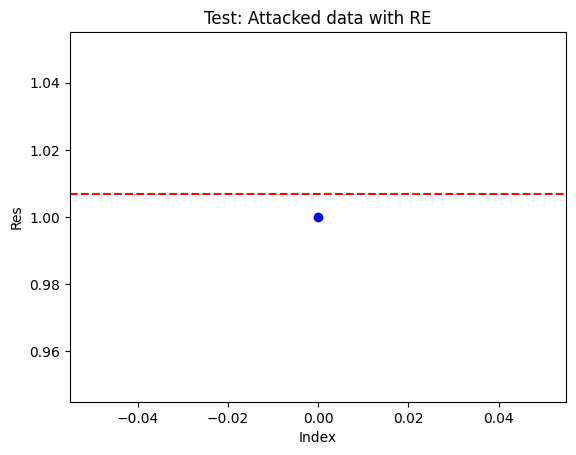

In [17]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in detection_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(detection_res_list)), detection_res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Test: Attacked data with RE')
plt.show()

In [18]:
sorted(forward_res_list, reverse=True)

[1.000450552578472,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525314251,
 1.0004505525196634,
 1.0004505524961187]

In [19]:
sorted(detection_res_list, reverse=True)

[1.000041228553356]